In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, sampler, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random

import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import pandas as pd

birds = os.listdir('../../CUB_200_2011/images/')

bird_names = {}

for i in birds:
        index, name = i.split('.')[0], i.split('.')[1]
        index = int(index) - 1
        bird_names[index] = name

bird_names = dict(sorted(bird_names.items(), key=lambda x:x[0]))
bird_names

{0: 'Black_footed_Albatross',
 1: 'Laysan_Albatross',
 2: 'Sooty_Albatross',
 3: 'Groove_billed_Ani',
 4: 'Crested_Auklet',
 5: 'Least_Auklet',
 6: 'Parakeet_Auklet',
 7: 'Rhinoceros_Auklet',
 8: 'Brewer_Blackbird',
 9: 'Red_winged_Blackbird',
 10: 'Rusty_Blackbird',
 11: 'Yellow_headed_Blackbird',
 12: 'Bobolink',
 13: 'Indigo_Bunting',
 14: 'Lazuli_Bunting',
 15: 'Painted_Bunting',
 16: 'Cardinal',
 17: 'Spotted_Catbird',
 18: 'Gray_Catbird',
 19: 'Yellow_breasted_Chat',
 20: 'Eastern_Towhee',
 21: 'Chuck_will_Widow',
 22: 'Brandt_Cormorant',
 23: 'Red_faced_Cormorant',
 24: 'Pelagic_Cormorant',
 25: 'Bronzed_Cowbird',
 26: 'Shiny_Cowbird',
 27: 'Brown_Creeper',
 28: 'American_Crow',
 29: 'Fish_Crow',
 30: 'Black_billed_Cuckoo',
 31: 'Mangrove_Cuckoo',
 32: 'Yellow_billed_Cuckoo',
 33: 'Gray_crowned_Rosy_Finch',
 34: 'Purple_Finch',
 35: 'Northern_Flicker',
 36: 'Acadian_Flycatcher',
 37: 'Great_Crested_Flycatcher',
 38: 'Least_Flycatcher',
 39: 'Olive_sided_Flycatcher',
 40: 'Scisso

In [5]:
bird_names_df = pd.DataFrame(bird_names.items(), columns=['index', 'Bird_name'])
bird_names_df.drop(['index'], axis=1, inplace=True)
bird_names_df.head()

,Bird_name
0,Black_footed_Albatross
1,Laysan_Albatross
2,Sooty_Albatross
3,Groove_billed_Ani
4,Crested_Auklet


In [8]:
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
  all_data = datasets.ImageFolder(data_dir, transform=transform)
  train_data_len = int(len(all_data)*0.75)
  valid_data_len = int((len(all_data) - train_data_len)/2)
  test_data_len = int(len(all_data) - train_data_len - valid_data_len)
  train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  return ((train_loader, val_loader, test_loader),train_data, val_data, test_data, all_data.classes)

In [9]:
(train_loader, val_loader, test_loader),train_data, val_data, test_data, classes = get_data_loaders("../../CUB_200_2011/images/", 64)

In [10]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

139
24
24


In [12]:
attributes = open('../../attributes.txt', 'r')
attribute_list = attributes.readlines()

attribute_cols = []

for i in range(len(attribute_list)):
    print(attribute_list[i].split(' ')[1].split('\n')[0])
    attribute_cols.append(attribute_list[i].split(' ')[1].split('\n')[0])

has_bill_shape::curved_(up_or_down)
has_bill_shape::dagger
has_bill_shape::hooked
has_bill_shape::needle
has_bill_shape::hooked_seabird
has_bill_shape::spatulate
has_bill_shape::all-purpose
has_bill_shape::cone
has_bill_shape::specialized
has_wing_color::blue
has_wing_color::brown
has_wing_color::iridescent
has_wing_color::purple
has_wing_color::rufous
has_wing_color::grey
has_wing_color::yellow
has_wing_color::olive
has_wing_color::green
has_wing_color::pink
has_wing_color::orange
has_wing_color::black
has_wing_color::white
has_wing_color::red
has_wing_color::buff
has_upperparts_color::blue
has_upperparts_color::brown
has_upperparts_color::iridescent
has_upperparts_color::purple
has_upperparts_color::rufous
has_upperparts_color::grey
has_upperparts_color::yellow
has_upperparts_color::olive
has_upperparts_color::green
has_upperparts_color::pink
has_upperparts_color::orange
has_upperparts_color::black
has_upperparts_color::white
has_upperparts_color::red
has_upperparts_color::buff
has_u

In [6]:
# 最大最小归一化
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [7]:
def plot_images(images, labels, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = labels[i]
        ax.set_title(label)
        ax.axis('off')

In [15]:
import pandas as pd

image_wise_attributes = open('../../CUB_200_2011/attributes/class_attribute_labels_continuous.txt', 'r')
image_wise_attributes = image_wise_attributes.readlines()
n = len(image_wise_attributes)
num_attributes = 312

attribute_df = pd.DataFrame(columns = attribute_cols)

for i in range(n):
    attribute_vals = []
    for j in range(num_attributes):
        attribute_vals.append(image_wise_attributes[i].split(' ')[j].split('\n')[0])

    attribute_vals = pd.DataFrame(data=[attribute_vals], columns=attribute_cols)
    attribute_df = pd.concat([attribute_df, attribute_vals], ignore_index=True)
attribute_df.head()

,has_bill_shape::curved_(up_or_down),has_bill_shape::dagger,has_bill_shape::hooked,has_bill_shape::needle,has_bill_shape::hooked_seabird,has_bill_shape::spatulate,has_bill_shape::all-purpose,has_bill_shape::cone,has_bill_shape::specialized,has_wing_color::blue,...,has_crown_color::pink,has_crown_color::orange,has_crown_color::black,has_crown_color::white,has_crown_color::red,has_crown_color::buff,has_wing_pattern::solid,has_wing_pattern::spotted,has_wing_pattern::striped,has_wing_pattern::multi-colored
0,0.0,2.9197080292,1.4598540146,0.0,59.8540145985,26.2773722628,3.6496350365,5.83941605839,0.0,1.6393442623,...,0.0,0.0,21.2765957447,11.3475177305,2.12765957447,31.914893617,53.5714285714,5.35714285714,21.4285714286,19.6428571429
1,4.41176470588,4.41176470588,2.94117647059,1.47058823529,57.3529411765,27.2058823529,0.0,2.20588235294,0.0,0.0,...,0.0,2.25563909774,2.25563909774,94.7368421053,0.0,0.0,77.1428571429,3.80952380952,10.4761904762,8.57142857143
2,0.0,3.97350993377,3.31125827815,0.0,70.8609271523,14.5695364238,5.29801324503,1.98675496689,0.0,0.0,...,2.20588235294,0.0,38.9705882353,2.94117647059,0.0,16.1764705882,71.0280373832,0.934579439252,7.47663551402,20.5607476636
3,0.0,1.4598540146,10.2189781022,0.0,0.0,0.0,8.75912408759,25.5474452555,54.0145985401,5.83941605839,...,0.0,0.0,88.5714285714,0.0,0.0,2.14285714286,84.126984127,2.38095238095,3.1746031746,10.3174603175
4,0.0,0.0,3.22580645161,0.0,1.0752688172,0.0,0.0,32.2580645161,63.4408602151,0.0,...,0.0,0.0,82.7272727273,5.45454545455,0.0,4.54545454545,88.4615384615,0.0,3.84615384615,7.69230769231


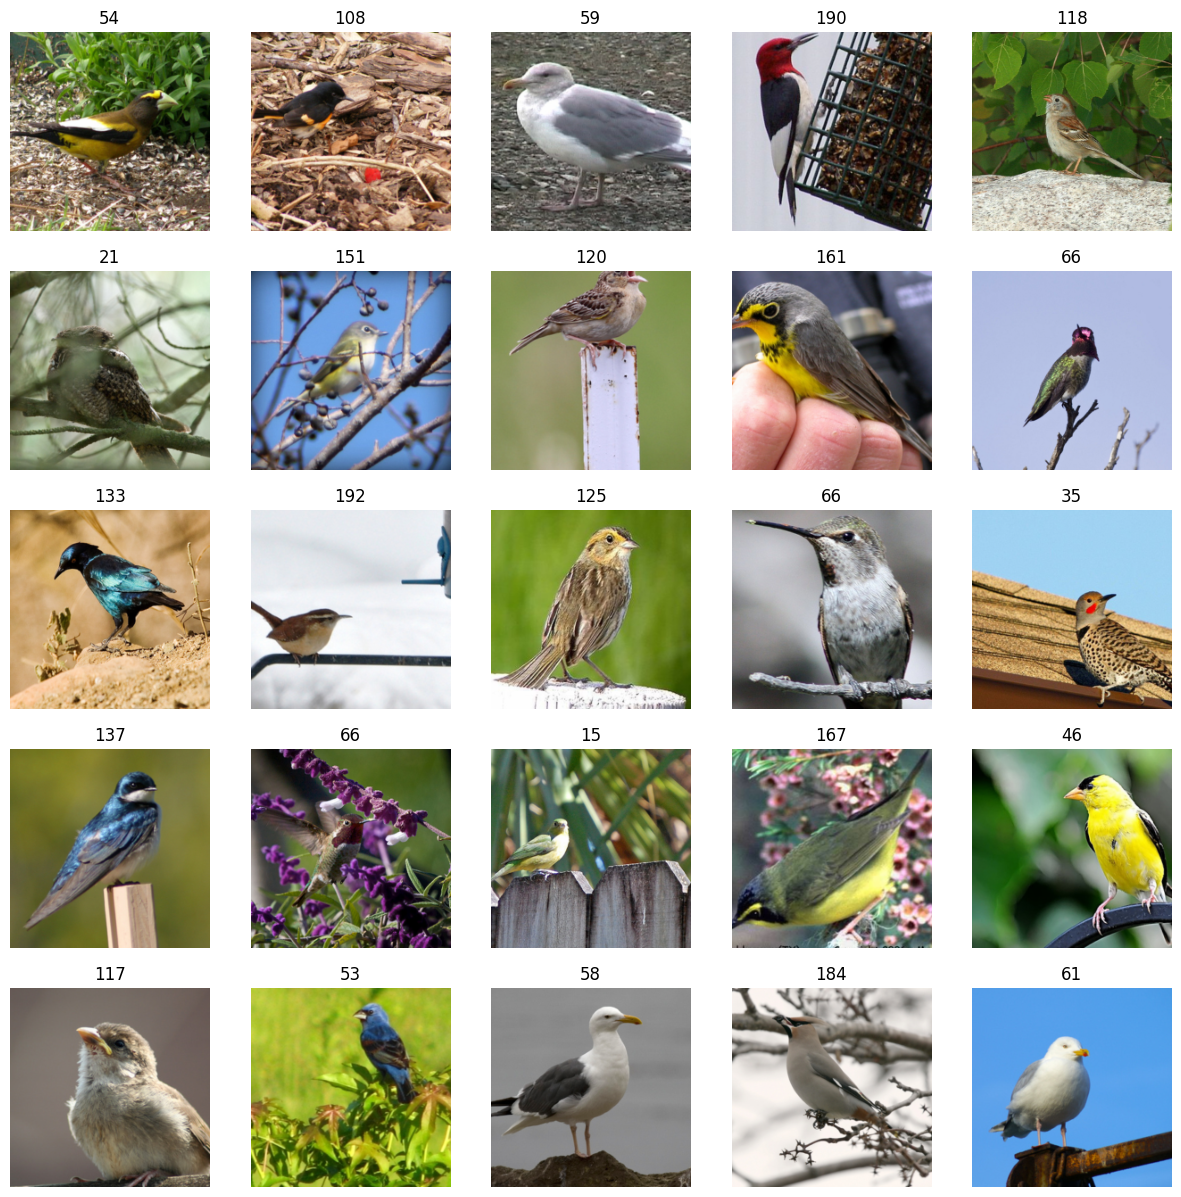

In [13]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

In [16]:
num_epochs = 10
CLASS_DIM = 200
CONCEPT_DIM = 312
lambda_reg = 0.01

attribute_df = attribute_df.astype(float)

In [17]:
import torch.nn.functional as F

class MultiTaskModel(nn.Module):
    def __init__(self, num_classes1, num_classes2, flag):
        super(MultiTaskModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Freeze the weights of the convolutional layers
        for param in self.resnet.parameters():
            param.requires_grad = flag

        # Add new fully connected layers
        self.fc1 = nn.Linear(1000, num_classes1)
        self.fc2 = nn.Linear(1000, num_classes2)

    def forward(self, x):
        x = self.resnet(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)

        return x1, x2

# For training the model from scratch, set flag=True
# For fine-tuning the model, set flag=False
flag=False
model = MultiTaskModel(CLASS_DIM, CONCEPT_DIM, flag)

C:\Users\杨大宇\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\杨大宇\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\杨大宇/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.40MB/s]


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 512,512 trainable parameters


In [19]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
gt_concept_vector = torch.tensor(attribute_df.values, dtype=torch.double).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lambda1 = 0.01
criterion1 = nn.CrossEntropyLoss()    # Don't use softmax in model definition if you are using cross entropy loss, function expects raw logits
criterion2 = nn.MSELoss()

model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        output1, output2 = model(image)
        loss1 = criterion1(output1, label)
        loss2 = criterion2(output2.double(), gt_concept_vector[label])

        loss = loss1 + lambda1*loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_instances, correct_preds = 0, 0

    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to(device), label.to(device)
            output1, output2 = model(image)
            output1 = torch.argmax(output1, dim=1)
            correct_preds += torch.sum(output1 == label).item()
            val_instances+=len(label)
        val_acc = (correct_preds*100)/val_instances
        print(f'Epoch {epoch}: Validation Accuracy = {val_acc}')

Epoch 0: Validation Accuracy = 51.18805159538357
Epoch 1: Validation Accuracy = 54.78615071283096
Epoch 2: Validation Accuracy = 56.551255940257974
Epoch 3: Validation Accuracy = 58.044806517311606
Epoch 4: Validation Accuracy = 57.026476578411405
Epoch 5: Validation Accuracy = 57.36591989137814
Epoch 6: Validation Accuracy = 58.72369314324508
Epoch 7: Validation Accuracy = 58.85947046843177
Epoch 8: Validation Accuracy = 57.298031228784794
Epoch 9: Validation Accuracy = 58.99524779361847


In [20]:
torch.save(model.state_dict(), "vgg.pth")

In [21]:
model.eval()
test_instances, correct_preds = 0, 0

with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output1, output2 = model(image)
        output1 = torch.argmax(output1, dim=1)
        correct_preds += torch.sum(output1 == label).item()
        test_instances+=len(label)
    test_acc = (correct_preds*100)/test_instances
    print(f'Test Accuracy = {test_acc}')

Test Accuracy = 57.869742198100404
